In [2]:
# ============================================================
# 1) Config & Imports — IEEE-39 (3-phase) Physics + KAN pipeline
# ------------------------------------------------------------
# What this cell does:
# - Imports core libs
# - Sets file paths, flags, and hyperparameters
# - Provides small helpers (safe H5 access, pretty printing)
# ============================================================

import os
import json
import math
import h5py
import numpy as np
import pandas as pd

from typing import Dict, List, Tuple, Optional

# --------------------------
# Paths (edit if needed)
# --------------------------
H5_PATH = "C:/Users/LBA100468/Documents/microgrid/Graph_model.h5"                 # your HDF5 static-physics export
ZONES_CSV = None                                # e.g. "data/zones.csv" with columns: idx,zone
OUT_DIR   = "results"                           # where to write CSV artifacts

# Ensure results dir exists
os.makedirs(OUT_DIR, exist_ok=True)

# --------------------------
# Hyperparameters & flags
# --------------------------
PHASES                = ["phase_a", "phase_b", "phase_c"]  # phases to try loading
MU_KERNEL             = 1e-3        # regularization for (L + mu I)^(-1)
N_LANDMARKS           = 12          # number of learnable landmark buses
USE_ZONE_QUOTAS       = False       # set True if you provide zones
QUOTAS_PER_ZONE: Optional[Dict] = None  # dict like {"0":4, "1":4, "2":4} or computed automatically

# Random seed for any randomized step (if added later)
RNG = np.random.default_rng(42)

# --------------------------
# Small helpers
# --------------------------
def pinfo(msg: str) -> None:
    print(f"[INFO] {msg}")

def pwarn(msg: str) -> None:
    print(f"[WARN] {msg}")

def perr(msg: str) -> None:
    print(f"[ERROR] {msg}")

def h5_has(f: h5py.File, path: str) -> bool:
    """Safe check if dataset/group exists in H5."""
    try:
        return f.get(path) is not None
    except Exception:
        return False

def safe_read_ds(f: h5py.File, path: str, required: bool = True) -> Optional[np.ndarray]:
    """Read a dataset if present, else return None or raise if required."""
    ds = f.get(path)
    if ds is None:
        if required:
            raise KeyError(f"Dataset not found: {path}")
        return None
    arr = np.array(ds[...])
    return arr

# --------------------------
# Quick path sanity check
# --------------------------
if not os.path.exists(H5_PATH):
    perr(f"H5 file not found: {H5_PATH}")
else:
    pinfo(f"H5 found: {H5_PATH}")

pinfo(f"Output directory: {OUT_DIR}")
pinfo(f"Zones CSV: {ZONES_CSV if ZONES_CSV else '(none)'}")
pinfo(f"Phases to load: {PHASES}")
pinfo(f"Landmarks target: {N_LANDMARKS}, Kernel μ = {MU_KERNEL}")


[INFO] H5 found: C:/Users/LBA100468/Documents/microgrid/Graph_model.h5
[INFO] Output directory: results
[INFO] Zones CSV: (none)
[INFO] Phases to load: ['phase_a', 'phase_b', 'phase_c']
[INFO] Landmarks target: 12, Kernel μ = 0.001


In [3]:
# ============================================================
# 2) Quick H5 Sanity Check & Inventory
# ------------------------------------------------------------
# What this cell does:
# - Opens the H5 file
# - Lists key datasets under /topology, /phases/*/{edges,nodes}, /steady_state
# - Checks required arrays exist (edge list, per-phase R/X/B, bus names, V_phys if present)
# - Prints short summaries so you can catch format mismatches early
# ============================================================

from IPython.display import display

def list_datasets(prefix: str = "") -> pd.DataFrame:
    rows = []
    with h5py.File(H5_PATH, "r") as f:
        def visit(name, obj):
            if isinstance(obj, h5py.Dataset) and (not prefix or name.startswith(prefix)):
                rows.append({"path": name, "shape": obj.shape, "dtype": str(obj.dtype)})
        f.visititems(visit)
    df = pd.DataFrame(rows).sort_values("path").reset_index(drop=True)
    return df

pinfo("Scanning H5 structure...")

# --- Topology inventory
try:
    df_topology = list_datasets("topology/")
    pinfo("Topology datasets:")
    display(df_topology.head(20))
except Exception as e:
    perr(f"Failed to scan /topology: {e}")
    df_topology = pd.DataFrame()

# --- Phases inventory (edges + nodes per phase)
phase_tables = {}
for ph in PHASES:
    try:
        df_edges = list_datasets(f"phases/{ph}/edges/")
        df_nodes = list_datasets(f"phases/{ph}/nodes/")
        phase_tables[ph] = (df_edges, df_nodes)
        pinfo(f"{ph}: edges:")
        display(df_edges.head(20))
        pinfo(f"{ph}: nodes:")
        display(df_nodes.head(20))
    except Exception as e:
        pwarn(f"Failed to scan {ph}: {e}")
        phase_tables[ph] = (pd.DataFrame(), pd.DataFrame())

# --- Steady-state inventory
try:
    df_steady = list_datasets("steady_state/")
    pinfo("Steady-state datasets:")
    display(df_steady.head(20))
except Exception as e:
    pwarn(f"Failed to scan /steady_state: {e}")
    df_steady = pd.DataFrame()

# --- Minimal required dataset checks
missing = []

with h5py.File(H5_PATH, "r") as f:
    # Topology: edge list
    if not h5_has(f, "topology/edge_list/from_bus"): missing.append("topology/edge_list/from_bus")
    if not h5_has(f, "topology/edge_list/to_bus"):   missing.append("topology/edge_list/to_bus")

    # Phase A as baseline (we will try B/C later if present)
    base_phase = None
    for ph in PHASES:
        if h5_has(f, f"phases/{ph}/edges/R_pu"):
            base_phase = ph
            break
    if base_phase is None:
        missing += [f"phases/{PHASES[0]}/edges/R_pu (or any phase edges set)"]

    if base_phase is not None:
        for d in ["edges/R_pu", "edges/X_pu", "edges/B_shunt_pu", "nodes/bus_names"]:
            if not h5_has(f, f"phases/{base_phase}/{d}"):
                missing.append(f"phases/{base_phase}/{d}")

    # Optional but nice to have: steady-state Vphys
    if not h5_has(f, "steady_state/power_flow_results/bus_voltages_pu"):
        pwarn("Optional: steady_state/power_flow_results/bus_voltages_pu not found (proxy & metrics will be limited).")

if missing:
    perr("Missing required datasets:")
    for m in missing:
        print(" -", m)
else:
    pinfo("All required baseline datasets are present.")

# --- Small shape summary (if available)
try:
    with h5py.File(H5_PATH, "r") as f:
        nb = None
        if h5_has(f, f"phases/{base_phase}/nodes/bus_names"):
            nb = len(np.array(f[f"phases/{base_phase}/nodes/bus_names"][...]))

        ne = None
        if h5_has(f, "topology/edge_list/from_bus"):
            ne = len(np.array(f["topology/edge_list/from_bus"][...]))

        pinfo(f"Detected buses: {nb if nb is not None else '?'} ; edges: {ne if ne is not None else '?'} ; base phase: {base_phase}")
except Exception as e:
    pwarn(f"Shape summary failed: {e}")


[INFO] Scanning H5 structure...
[INFO] Topology datasets:


,path,shape,dtype
0,topology/edge_list/edge_type,"(46,)",int64
1,topology/edge_list/from_bus,"(46,)",int64
2,topology/edge_list/to_bus,"(46,)",int64


[INFO] phase_a: edges:


,path,shape,dtype
0,phases/phase_a/edges/B_shunt_pu,"(46,)",float64
1,phases/phase_a/edges/R_pu,"(46,)",float64
2,phases/phase_a/edges/X_pu,"(46,)",float64
3,phases/phase_a/edges/element_id,"(46,)",|S50
4,phases/phase_a/edges/element_type,"(46,)",int64
5,phases/phase_a/edges/from_bus,"(46,)",int64
6,phases/phase_a/edges/in_service,"(46,)",bool
7,phases/phase_a/edges/length_km,"(46,)",float64
8,phases/phase_a/edges/rating_MVA,"(46,)",float64
9,phases/phase_a/edges/to_bus,"(46,)",int64


[INFO] phase_a: nodes:


,path,shape,dtype
0,phases/phase_a/nodes/P_generation_MW,"(39,)",float64
1,phases/phase_a/nodes/P_injection_MW,"(39,)",float64
2,phases/phase_a/nodes/P_load_MW,"(39,)",float64
3,phases/phase_a/nodes/Q_generation_MVAR,"(39,)",float64
4,phases/phase_a/nodes/Q_injection_MVAR,"(39,)",float64
5,phases/phase_a/nodes/Q_load_MVAR,"(39,)",float64
6,phases/phase_a/nodes/angles_deg,"(39,)",float64
7,phases/phase_a/nodes/base_voltages_kV,"(39,)",float64
8,phases/phase_a/nodes/bus_ids,"(39,)",int64
9,phases/phase_a/nodes/bus_names,"(39,)",|S50


[INFO] phase_b: edges:


,path,shape,dtype
0,phases/phase_b/edges/B_shunt_pu,"(46,)",float64
1,phases/phase_b/edges/R_pu,"(46,)",float64
2,phases/phase_b/edges/X_pu,"(46,)",float64
3,phases/phase_b/edges/element_id,"(46,)",|S50
4,phases/phase_b/edges/element_type,"(46,)",int64
5,phases/phase_b/edges/from_bus,"(46,)",int64
6,phases/phase_b/edges/in_service,"(46,)",bool
7,phases/phase_b/edges/length_km,"(46,)",float64
8,phases/phase_b/edges/rating_MVA,"(46,)",float64
9,phases/phase_b/edges/to_bus,"(46,)",int64


[INFO] phase_b: nodes:


,path,shape,dtype
0,phases/phase_b/nodes/P_generation_MW,"(39,)",float64
1,phases/phase_b/nodes/P_injection_MW,"(39,)",float64
2,phases/phase_b/nodes/P_load_MW,"(39,)",float64
3,phases/phase_b/nodes/Q_generation_MVAR,"(39,)",float64
4,phases/phase_b/nodes/Q_injection_MVAR,"(39,)",float64
5,phases/phase_b/nodes/Q_load_MVAR,"(39,)",float64
6,phases/phase_b/nodes/angles_deg,"(39,)",float64
7,phases/phase_b/nodes/base_voltages_kV,"(39,)",float64
8,phases/phase_b/nodes/bus_ids,"(39,)",int64
9,phases/phase_b/nodes/bus_names,"(39,)",|S50


[INFO] phase_c: edges:


,path,shape,dtype
0,phases/phase_c/edges/B_shunt_pu,"(46,)",float64
1,phases/phase_c/edges/R_pu,"(46,)",float64
2,phases/phase_c/edges/X_pu,"(46,)",float64
3,phases/phase_c/edges/element_id,"(46,)",|S50
4,phases/phase_c/edges/element_type,"(46,)",int64
5,phases/phase_c/edges/from_bus,"(46,)",int64
6,phases/phase_c/edges/in_service,"(46,)",bool
7,phases/phase_c/edges/length_km,"(46,)",float64
8,phases/phase_c/edges/rating_MVA,"(46,)",float64
9,phases/phase_c/edges/to_bus,"(46,)",int64


[INFO] phase_c: nodes:


,path,shape,dtype
0,phases/phase_c/nodes/P_generation_MW,"(39,)",float64
1,phases/phase_c/nodes/P_injection_MW,"(39,)",float64
2,phases/phase_c/nodes/P_load_MW,"(39,)",float64
3,phases/phase_c/nodes/Q_generation_MVAR,"(39,)",float64
4,phases/phase_c/nodes/Q_injection_MVAR,"(39,)",float64
5,phases/phase_c/nodes/Q_load_MVAR,"(39,)",float64
6,phases/phase_c/nodes/angles_deg,"(39,)",float64
7,phases/phase_c/nodes/base_voltages_kV,"(39,)",float64
8,phases/phase_c/nodes/bus_ids,"(39,)",int64
9,phases/phase_c/nodes/bus_names,"(39,)",|S50


[INFO] Steady-state datasets:


,path,shape,dtype
0,steady_state/power_flow_results/bus_angles_deg,"(39,)",float64
1,steady_state/power_flow_results/bus_names,"(39,)",object
2,steady_state/power_flow_results/bus_voltages_pu,"(39,)",float64
3,steady_state/power_flow_results/gen_P_MW,"(39,)",float64
4,steady_state/power_flow_results/gen_Q_MVAR,"(39,)",float64
5,steady_state/power_flow_results/load_P_MW,"(39,)",float64
6,steady_state/power_flow_results/load_Q_MVAR,"(39,)",float64


[INFO] All required baseline datasets are present.
[INFO] Detected buses: 39 ; edges: 46 ; base phase: phase_a


In [4]:
# ============================================================
# 3) Load Core Data (buses, edges, per-phase R/X/B, P/Q/V, V_phys)
# ------------------------------------------------------------
# What this cell does:
# - Reads bus names and the edge list (from_bus, to_bus)
# - For each available phase, loads edges {R_pu, X_pu, B_shunt_pu}
#   and nodes {P/Q gen/load/injection, voltages_pu}
# - Loads steady-state V_phys if present
# - Builds convenience containers for later steps
# ============================================================

# Containers
BUS_NAMES: List[str] = []
FROM_BUS: np.ndarray = None
TO_BUS:   np.ndarray = None
AVAILABLE_PHASES: List[str] = []

PHASE_EDGES: Dict[str, Dict[str, np.ndarray]] = {}   # phase -> {"R_pu","X_pu","B_shunt_pu"}
PHASE_NODES: Dict[str, Dict[str, np.ndarray]] = {}   # phase -> {"P_gen","P_load","P_inj","Q_gen","Q_load","Q_inj","V_obs"}

V_PHYS: Optional[np.ndarray] = None  # (N,) or (N,3) if steady-state PF voltages are available

# --- Read topology (edge list) and pick available phases
with h5py.File(H5_PATH, "r") as f:
    # Bus names (take them from the first phase that has nodes/bus_names)
    base_phase_for_names = None
    for ph in PHASES:
        if h5_has(f, f"phases/{ph}/nodes/bus_names"):
            base_phase_for_names = ph
            break
    if base_phase_for_names is None:
        raise KeyError("No bus_names found under phases/*/nodes/bus_names")

    raw_names = safe_read_ds(f, f"phases/{base_phase_for_names}/nodes/bus_names")
    BUS_NAMES = [s.decode("utf-8") if hasattr(s, "decode") else str(s) for s in raw_names]

    # Edge list
    FROM_BUS = safe_read_ds(f, "topology/edge_list/from_bus")
    TO_BUS   = safe_read_ds(f, "topology/edge_list/to_bus")

    # Detect phases that have edge impedances
    for ph in PHASES:
        if h5_has(f, f"phases/{ph}/edges/R_pu") and h5_has(f, f"phases/{ph}/edges/X_pu") and h5_has(f, f"phases/{ph}/edges/B_shunt_pu"):
            AVAILABLE_PHASES.append(ph)

    # Steady-state V_phys (optional)
    if h5_has(f, "steady_state/power_flow_results/bus_voltages_pu"):
        V_PHYS = safe_read_ds(f, "steady_state/power_flow_results/bus_voltages_pu", required=False)

pinfo(f"Loaded bus names: {len(BUS_NAMES)}")
pinfo(f"Edges: {len(FROM_BUS)} ; Available phases with R/X/B: {AVAILABLE_PHASES}")

# --- Per-phase loads: edges and nodes
with h5py.File(H5_PATH, "r") as f:
    for ph in AVAILABLE_PHASES:
        # Edges
        Rpu = safe_read_ds(f, f"phases/{ph}/edges/R_pu")
        Xpu = safe_read_ds(f, f"phases/{ph}/edges/X_pu")
        Bpu = safe_read_ds(f, f"phases/{ph}/edges/B_shunt_pu")
        PHASE_EDGES[ph] = {"R_pu": Rpu, "X_pu": Xpu, "B_shunt_pu": Bpu}

        # Nodes (use get+fallbacks; not all datasets are strictly required)
        def opt(path): 
            ds = f.get(path)
            return None if ds is None else np.array(ds[...])

        P_gen = opt(f"phases/{ph}/nodes/P_generation_MW")
        P_load= opt(f"phases/{ph}/nodes/P_load_MW")
        P_inj = opt(f"phases/{ph}/nodes/P_injection_MW")
        Q_gen = opt(f"phases/{ph}/nodes/Q_generation_MVAR")
        Q_load= opt(f"phases/{ph}/nodes/Q_load_MVAR")
        Q_inj = opt(f"phases/{ph}/nodes/Q_injection_MVAR")

        # Observed per-phase voltages if present (treated as V_obs for proxy)
        V_obs = opt(f"phases/{ph}/nodes/voltages_pu")

        PHASE_NODES[ph] = {
            "P_gen": P_gen, "P_load": P_load, "P_inj": P_inj,
            "Q_gen": Q_gen, "Q_load": Q_load, "Q_inj": Q_inj,
            "V_obs": V_obs
        }

# --- Basic consistency checks
N = len(BUS_NAMES)
M = len(FROM_BUS)

if any(len(arr) != M for arr in [PHASE_EDGES[p]["R_pu"] for p in AVAILABLE_PHASES]):
    pwarn("Edge count mismatch for R_pu arrays vs edge list length.")

if any(len(arr) != M for arr in [PHASE_EDGES[p]["X_pu"] for p in AVAILABLE_PHASES]):
    pwarn("Edge count mismatch for X_pu arrays vs edge list length.")

if any(len(arr) != M for arr in [PHASE_EDGES[p]["B_shunt_pu"] for p in AVAILABLE_PHASES]):
    pwarn("Edge count mismatch for B_shunt_pu arrays vs edge list length.")

for ph in AVAILABLE_PHASES:
    vobs = PHASE_NODES[ph]["V_obs"]
    if vobs is not None and len(vobs) != N:
        pwarn(f"{ph}: voltages_pu length {len(vobs)} != number of buses {N}")

if V_PHYS is not None:
    if V_PHYS.ndim == 1 and V_PHYS.shape[0] != N:
        pwarn(f"V_PHYS shape {V_PHYS.shape} does not match bus count {N}")
    if V_PHYS.ndim == 2 and V_PHYS.shape[0] != N:
        pwarn(f"V_PHYS shape {V_PHYS.shape} does not match bus count {N}")

# --- Short human-readable summaries
pinfo("Core data loaded.")
print(f"- Buses: {N} | Edges: {M}")
for ph in AVAILABLE_PHASES:
    ed = PHASE_EDGES[ph]
    nd = PHASE_NODES[ph]
    print(f"  * {ph}: edges R/X/B shapes = {ed['R_pu'].shape}/{ed['X_pu'].shape}/{ed['B_shunt_pu'].shape} | V_obs: {'yes' if nd['V_obs'] is not None else 'no'}")

if V_PHYS is not None:
    print(f"- V_PHYS shape: {V_PHYS.shape} (steady_state)")
else:
    print("- V_PHYS: not found (steady_state PF voltages missing)")

# Convenience aliases for later cells
BUS_INDEX = pd.DataFrame({"idx": np.arange(N), "bus": BUS_NAMES})
EDGE_TABLE = pd.DataFrame({"from": FROM_BUS, "to": TO_BUS})
display(BUS_INDEX.head())
display(EDGE_TABLE.head())


[INFO] Loaded bus names: 39
[INFO] Edges: 46 ; Available phases with R/X/B: ['phase_a', 'phase_b', 'phase_c']
[INFO] Core data loaded.
- Buses: 39 | Edges: 46
  * phase_a: edges R/X/B shapes = (46,)/(46,)/(46,) | V_obs: yes
  * phase_b: edges R/X/B shapes = (46,)/(46,)/(46,) | V_obs: yes
  * phase_c: edges R/X/B shapes = (46,)/(46,)/(46,) | V_obs: yes
- V_PHYS shape: (39,) (steady_state)


,idx,bus
0,0,Bus 01
1,1,Bus 02
2,2,Bus 03
3,3,Bus 04
4,4,Bus 05


,from,to
0,0,1
1,0,38
2,1,2
3,1,24
4,2,3


In [5]:
# ============================================================
# 4) Build per-phase Ybus (π-model) + sanity checks
# ------------------------------------------------------------
# What this cell does:
# - For each available phase, builds a sparse nodal admittance Ybus
#   using a standard π-model:
#       y_series = 1 / (R + jX)
#       shunt at each end = j * (B_shunt) / 2
# - Provides helpers for quick dense previews and block-diag assembly
# - Runs basic sanity checks (shape, symmetry, nnz)
# ============================================================

from typing import Dict
import numpy as np
import scipy.sparse as sp

# ---- Config / numerics
_COMPLEX_DTYPE = np.complex128
_EPS = 1e-12

# ---- Outputs
YBUS: Dict[str, sp.csr_matrix] = {}

def build_ybus_pi_model(
    N: int,
    from_bus: np.ndarray,
    to_bus: np.ndarray,
    R_pu: np.ndarray,
    X_pu: np.ndarray,
    B_shunt_pu: np.ndarray,
) -> sp.csr_matrix:
    """
    Build Ybus (CSR) with a π-model per edge.
    Conventions:
      - y_series = 1 / (R + jX)
      - Off-diagonal: Y[i,j] -= y_series ; Y[j,i] = Y[i,j]
      - Diagonal: add y_series at both ends
      - Shunt: add +j * (B/2) to each end's diagonal
    """
    assert len(from_bus) == len(to_bus) == len(R_pu) == len(X_pu) == len(B_shunt_pu), \
        "Edge arrays must have the same length"

    i_idx = from_bus.astype(int)
    j_idx = to_bus.astype(int)

    z = R_pu.astype(_COMPLEX_DTYPE) + 1j * X_pu.astype(_COMPLEX_DTYPE)

    # avoid divide-by-zero
    bad = np.abs(z) < _EPS
    if np.any(bad):
        # Replace near-zero impedances with tiny impedance to avoid inf
        z = z.copy()
        z[bad] = _EPS + 1j * _EPS

    y_series = 1.0 / z
    y_sh_half = 1j * (B_shunt_pu.astype(_COMPLEX_DTYPE) / 2.0)

    # We assemble in COO then convert to CSR
    rows = []
    cols = []
    data = []

    # Off-diagonals: -y_series for (i,j) and (j,i)
    rows.extend(i_idx.tolist()); cols.extend(j_idx.tolist()); data.extend((-y_series).tolist())
    rows.extend(j_idx.tolist()); cols.extend(i_idx.tolist()); data.extend((-y_series).tolist())

    # Diagonals: add y_series to both ends
    # We'll accumulate duplicates naturally in COO -> CSR sum
    rows.extend(i_idx.tolist()); cols.extend(i_idx.tolist()); data.extend((+y_series).tolist())
    rows.extend(j_idx.tolist()); cols.extend(j_idx.tolist()); data.extend((+y_series).tolist())

    # Shunts: +j*B/2 to both end-node diagonals
    rows.extend(i_idx.tolist()); cols.extend(i_idx.tolist()); data.extend((+y_sh_half).tolist())
    rows.extend(j_idx.tolist()); cols.extend(j_idx.tolist()); data.extend((+y_sh_half).tolist())

    Y_coo = sp.coo_matrix((np.array(data, dtype=_COMPLEX_DTYPE),
                           (np.array(rows, dtype=int), np.array(cols, dtype=int))),
                           shape=(N, N))
    Y_csr = Y_coo.tocsr()
    Y_csr.sum_duplicates()
    return Y_csr

def ybus_preview_dense(Y: sp.csr_matrix, k: int = 8) -> np.ndarray:
    """
    Return a small dense top-left preview of Y (k x k).
    """
    k = min(k, Y.shape[0])
    return Y[:k, :k].toarray()

def block_diag_from_dict(mats: Dict[str, sp.csr_matrix], order: list) -> sp.csr_matrix:
    """
    Build a block-diagonal matrix stacking mats[ph] in 'order'.
    """
    blocks = [mats[ph] for ph in order if ph in mats]
    if not blocks:
        raise ValueError("No matrices to stack.")
    return sp.block_diag(blocks, format="csr", dtype=_COMPLEX_DTYPE)

# ---- Build Ybus per available phase
for ph in AVAILABLE_PHASES:
    edges = PHASE_EDGES[ph]
    Rpu = np.asarray(edges["R_pu"]).flatten()
    Xpu = np.asarray(edges["X_pu"]).flatten()
    Bpu = np.asarray(edges["B_shunt_pu"]).flatten()

    YBUS[ph] = build_ybus_pi_model(
        N=N,
        from_bus=FROM_BUS,
        to_bus=TO_BUS,
        R_pu=Rpu,
        X_pu=Xpu,
        B_shunt_pu=Bpu,
    )

# ---- Sanity checks
print("=== Ybus per phase ===")
for ph in AVAILABLE_PHASES:
    Y = YBUS[ph]
    # Shapes
    ok_shape = (Y.shape == (N, N))
    # Basic symmetry check (Hermitian in passive networks). We check numeric closeness.
    # Note: numerical shunts/rounding may introduce tiny asymmetry; we use a tolerance.
    sym_resid = (Y - Y.T).nnz == 0 or np.max(np.abs((Y - Y.T).data)) if (Y - Y.T).nnz > 0 else 0.0
    nnz = Y.nnz
    print(f"  * {ph}: shape {Y.shape}, nnz={nnz}, symmetry_residual≈{sym_resid:.2e}" if isinstance(sym_resid,float) else
          f"  * {ph}: shape {Y.shape}, nnz={nnz}, symmetry_residual≈0")

# ---- Optional: build a block-diagonal multi-phase Y (e.g., order = ['a','b','c'])
if len(AVAILABLE_PHASES) > 1:
    PHASE_ORDER = sorted(AVAILABLE_PHASES)  # or custom order like ['a','b','c']
    YBLOCK = block_diag_from_dict(YBUS, PHASE_ORDER)
    print(f"- Built block-diagonal YBLOCK with order={PHASE_ORDER}, shape={YBLOCK.shape}, nnz={YBLOCK.nnz}")
else:
    YBLOCK = None
    print("- Single phase available -> no block-diagonal matrix built.")

# ---- Quick preview (top-left) for the first available phase
if AVAILABLE_PHASES:
    ph0 = AVAILABLE_PHASES[0]
    preview = ybus_preview_dense(YBUS[ph0], k=6)
    print(f"\nTop-left preview of Ybus[{ph0}] (6x6):")
    # Show real/imag separately for readability
    with np.printoptions(precision=3, suppress=True):
        print("Re:\n", preview.real)
        print("Im:\n", preview.imag)


=== Ybus per phase ===
  * phase_a: shape (39, 39), nnz=131, symmetry_residual≈0.00e+00
  * phase_b: shape (39, 39), nnz=131, symmetry_residual≈0.00e+00
  * phase_c: shape (39, 39), nnz=131, symmetry_residual≈0.00e+00
- Built block-diagonal YBLOCK with order=['phase_a', 'phase_b', 'phase_c'], shape=(117, 117), nnz=393

Top-left preview of Ybus[phase_a] (6x6):
Re:
 [[ 4.114 -2.057  0.     0.     0.     0.   ]
 [-2.057  8.228 -2.057  0.     0.     0.   ]
 [ 0.    -2.057  6.171 -2.057  0.     0.   ]
 [ 0.     0.    -2.057  6.171 -2.057  0.   ]
 [ 0.     0.     0.    -2.057  6.171 -2.057]
 [ 0.     0.     0.     0.    -2.057  8.228]]
Im:
 [[-48.311  24.156   0.      0.      0.      0.   ]
 [ 24.156 -96.623  24.156   0.      0.      0.   ]
 [  0.     24.156 -72.467  24.156   0.      0.   ]
 [  0.      0.     24.156 -72.467  24.156   0.   ]
 [  0.      0.      0.     24.156 -72.467  24.156]
 [  0.      0.      0.      0.     24.156 -96.623]]


In [8]:
# ============================================================
# 5) KCL operator + slack handling + baseline per-phase solve
# ------------------------------------------------------------
# What this cell does:
# - Builds nodal current injections I_inj from P/Q using per-unit scaling
# - Handles a chosen slack bus (fixed voltage) and solves the reduced system
# - Provides helpers for KCL mismatch and edge currents
# - Prints diagnostics (|V| scale, KCL residuals, top offending buses)
# ============================================================

from typing import Dict, Optional, Tuple
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# ---- Expected from previous cells (Phase 2 & 4):
# BUS_NAMES, FROM_BUS, TO_BUS, AVAILABLE_PHASES, PHASE_EDGES, PHASE_NODES, YBUS, N, M

# ---- Config
BASE_MVA: float = 100.0              # system base MVA (adjust to your dataset)
S_INPUT_UNITS = "MW_MVAr"            # set to "per_unit" if P/Q are already in pu in your H5
SLACK_BUS: int = 0                   # default slack index (can be overridden per phase)
V_SLACK: complex = 1.0 + 0.0j        # fixed slack voltage (pu)
_EPS = 1e-12

# ---- Outputs
IINJ: Dict[str, np.ndarray] = {}     # nodal current injections (N,) complex, per-unit
V_BASE: Dict[str, np.ndarray] = {}   # baseline voltage solution (N,) complex

# -------------------------
# Utilities
# -------------------------
def build_complex_power(ph_nodes: Dict[str, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns P(MW or pu), Q(MVAr or pu) arrays (N,). Uses fallbacks if P_inj/Q_inj are missing.
    Convention: positive P means net injection (gen - load).
    """
    def get_or_none(k): 
        arr = ph_nodes.get(k, None)
        return None if arr is None else np.asarray(arr).flatten()

    P_inj = get_or_none("P_inj")
    Q_inj = get_or_none("Q_inj")
    if P_inj is None or Q_inj is None:
        P_gen = get_or_none("P_gen"); P_load = get_or_none("P_load")
        Q_gen = get_or_none("Q_gen"); Q_load = get_or_none("Q_load")
        if P_gen is None and P_load is None and Q_gen is None and Q_load is None:
            raise KeyError("No P/Q data available (neither P_inj/Q_inj nor gen/load).")
        P = (np.nan_to_num(P_gen) if P_gen is not None else 0.0) - (np.nan_to_num(P_load) if P_load is not None else 0.0)
        Q = (np.nan_to_num(Q_gen) if Q_gen is not None else 0.0) - (np.nan_to_num(Q_load) if Q_load is not None else 0.0)
    else:
        P = np.nan_to_num(P_inj)
        Q = np.nan_to_num(Q_inj)
    return P, Q

def power_to_current(P: np.ndarray, Q: np.ndarray, V_ref: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Convert S=P+jQ to nodal current injection I in per-unit.
    If S is in MW/MVAr, divide by BASE_MVA before using I = conj(S_pu / V_ref).
    If V_ref is None, use flat 1∠0. If V_ref is real-only magnitudes, assume zero angle.
    """
    P = np.asarray(P, dtype=np.float64).flatten()
    Q = np.asarray(Q, dtype=np.float64).flatten()

    # Convert to per-unit if needed
    if S_INPUT_UNITS.lower().startswith("mw"):
        Spu = (P + 1j*Q) / BASE_MVA
    else:
        Spu = (P + 1j*Q).astype(np.complex128)

    if V_ref is None:
        V_ref = np.ones_like(Spu, dtype=np.complex128)
    else:
        V_ref = np.asarray(V_ref, dtype=np.complex128).flatten()
        if np.isrealobj(V_ref):
            V_ref = V_ref + 0j
        V_ref = V_ref.copy()
        V_ref[np.abs(V_ref) < 1e-9] = 1.0 + 0.0j

    return np.conj(Spu / V_ref)

def solve_with_slack(Y: sp.csr_matrix, I: np.ndarray, slack: int, v_slack: complex) -> np.ndarray:
    """
    Solve Y * V = I with voltage fixed at 'slack' bus.
    Reduce the system by removing slack row/col and correcting RHS by Y[:,slack]*V_slack.
    Broadcasting-safe conversion for Yus column included.
    """
    n = Y.shape[0]
    if not (0 <= slack < n):
        raise IndexError(f"SLACK_BUS={slack} out of range for Y shape {Y.shape}")

    mask = np.ones(n, dtype=bool)
    mask[slack] = False

    # Partition
    Yuu = Y[mask][:, mask]          # (n-1, n-1)
    Yus = Y[mask][:, slack]         # (n-1, 1) sparse column

    # Ensure 1D arrays for RHS build
    Iu = np.asarray(I[mask], dtype=np.complex128)
    Yus_vec = Yus.toarray().ravel().astype(np.complex128)   # (n-1,)

    # RHS correction from fixed slack voltage
    Iu = Iu - Yus_vec * np.complex128(v_slack)

    # Solve
    try:
        V_unknown = spla.spsolve(Yuu, Iu)
    except Exception:
        # Fallback least-squares if singular/ill-conditioned
        V_unknown, *_ = spla.lsmr(Yuu, Iu)

    # Recompose full V
    V = np.zeros(n, dtype=np.complex128)
    V[slack] = np.complex128(v_slack)
    V[mask]  = V_unknown
    return V

def series_admittance_for_phase(ph: str) -> np.ndarray:
    """Return per-edge series admittance y_series = 1/(R+jX) for phase ph."""
    edges = PHASE_EDGES[ph]
    z = edges["R_pu"].astype(np.complex128) + 1j * edges["X_pu"].astype(np.complex128)
    z[np.abs(z) < _EPS] = _EPS + 1j * _EPS
    return 1.0 / z

def edge_currents_from_voltages(V: np.ndarray, y_series: np.ndarray) -> np.ndarray:
    """
    Edge currents I_e flowing from 'from_bus' to 'to_bus':
      I_e = y_series * (V_i - V_j)
    Returns (M,) complex.
    """
    Vi = V[FROM_BUS.astype(int)]
    Vj = V[TO_BUS.astype(int)]
    return y_series * (Vi - Vj)

def kcl_mismatch(Y: sp.csr_matrix, V: np.ndarray, I: np.ndarray) -> np.ndarray:
    """Return nodal mismatch: r = Y V - I (should be ~0 at solution)."""
    return Y.dot(V) - I

def pick_slack_bus(P: np.ndarray, prefer: Optional[int] = None) -> int:
    """
    Pick a slack bus index. If 'prefer' provided/valid, use it.
    Else heuristic: bus with the largest positive net P injection.
    """
    if prefer is not None and 0 <= prefer < len(P):
        return prefer
    return int(np.nanargmax(P))

def quick_diagnostics(ph: str):
    """Print basic scale checks and top-5 KCL residual buses."""
    P, Q = build_complex_power(PHASE_NODES[ph])
    if S_INPUT_UNITS.lower().startswith("mw"):
        Ppu, Qpu = P/BASE_MVA, Q/BASE_MVA
    else:
        Ppu, Qpu = P, Q

    mis = kcl_mismatch(YBUS[ph], V_BASE[ph], IINJ[ph])
    magV = np.abs(V_BASE[ph])

    print(f"[{ph}]  |V| mean={magV.mean():.3f}, max={magV.max():.3f}")
    print(f"[{ph}]  KCL |.|_inf={np.abs(mis).max():.3e}, |.|_2={np.linalg.norm(mis):.3e}")
    print(f"[{ph}]  mean(|P|_pu)={np.mean(np.abs(Ppu)):.3e}, mean(|Q|_pu)={np.mean(np.abs(Qpu)):.3e}")

    idx_top = np.argsort(-np.abs(mis))[:5]
    for k in idx_top:
        bus_name = BUS_NAMES[k] if k < len(BUS_NAMES) else str(k)
        print(f"    bus {k:3d} ({bus_name}): |mis|={np.abs(mis[k]):.3e}, |V|={magV[k]:.3f}, "
              f"Ppu={Ppu[k]:.3e}, Qpu={Qpu[k]:.3e}")

# -------------------------
# Build IINJ and baseline voltages per phase
# -------------------------
for ph in AVAILABLE_PHASES:
    # 1) Build P, Q
    P, Q = build_complex_power(PHASE_NODES[ph])

    # 2) Optionally (re)choose slack (keeps your manual SLACK_BUS if provided)
    SLACK_BUS = pick_slack_bus(P, prefer=SLACK_BUS)

    # 3) Build I_inj in per-unit; if measured V exists for phase, use as V_ref
    V_ref = PHASE_NODES[ph].get("V_obs", None)
    I = power_to_current(P, Q, V_ref=V_ref)
    IINJ[ph] = I

    # 4) Solve reduced system with slack
    Y = YBUS[ph]
    V = solve_with_slack(Y, I, slack=SLACK_BUS, v_slack=V_SLACK)
    V_BASE[ph] = V

# -------------------------
# Diagnostics & edge preview
# -------------------------
print("=== Baseline per-phase solve (with slack; per-unit consistent) ===")
for ph in AVAILABLE_PHASES:
    mis = kcl_mismatch(YBUS[ph], V_BASE[ph], IINJ[ph])
    print(f"  * {ph}: |mismatch|_inf = {np.max(np.abs(mis)):.3e}, |V| mean = {np.mean(np.abs(V_BASE[ph])):.3f}")

# Edge currents preview for the first available phase
if AVAILABLE_PHASES:
    ph0 = AVAILABLE_PHASES[0]
    yser = series_admittance_for_phase(ph0)
    Iedge = edge_currents_from_voltages(V_BASE[ph0], yser)
    print(f"\nEdge currents preview [{ph0}] (first 8):")
    with np.printoptions(precision=4, suppress=True):
        print(Iedge[:8])

# Optional: deeper per-phase diagnostics
for ph in AVAILABLE_PHASES:
    quick_diagnostics(ph)


=== Baseline per-phase solve (with slack; per-unit consistent) ===
  * phase_a: |mismatch|_inf = 5.535e-01, |V| mean = 1.027
  * phase_b: |mismatch|_inf = 5.535e-01, |V| mean = 1.027
  * phase_c: |mismatch|_inf = 5.535e-01, |V| mean = 1.027

Edge currents preview [phase_a] (first 8):
[-0.7302+0.0589j  0.5402-0.5787j  0.9769-0.1814j -0.9115-0.2248j
  0.1734-0.2613j -0.2384+0.0876j -0.3518+0.0252j -1.1351+0.3245j]
[phase_a]  |V| mean=1.027, max=1.131
[phase_a]  KCL |.|_inf=5.535e-01, |.|_2=5.535e-01
[phase_a]  mean(|P|_pu)=8.735e-01, mean(|Q|_pu)=2.272e-01
    bus   0 (Bus 01): |mis|=5.535e-01, |V|=1.000, Ppu=0.000e+00, Qpu=0.000e+00
    bus   3 (Bus 04): |mis|=1.865e-14, |V|=0.983, Ppu=-1.667e+00, Qpu=-6.133e-01
    bus  12 (Bus 13): |mis|=1.438e-14, |V|=1.017, Ppu=0.000e+00, Qpu=0.000e+00
    bus  11 (Bus 12): |mis|=1.356e-14, |V|=1.011, Ppu=-2.500e-02, Qpu=-2.933e-01
    bus  28 (Bus 29): |mis|=1.198e-14, |V|=1.003, Ppu=-9.450e-01, Qpu=-8.967e-02
[phase_b]  |V| mean=1.027, max=1.131
[

In [9]:
# ============================================================
# 6) Feature blocks + masks + normalization
# ------------------------------------------------------------
# What this cell does:
# - Builds per-node, per-phase feature matrices X[phase] (N x F)
# - Builds masks: slack, observed (V_obs), gen/load (by P sign), optional zones
# - Builds targets: V_target (prefer V_obs; else V_BASE), optional V_phys
# - Normalizes features with robust mean/std (ignores NaN/Inf)
# - Tries to reuse existing selections/splits if provided by your env
# ============================================================

from typing import Dict, Optional, Tuple
import numpy as np
import pandas as pd
import scipy.sparse as sp

# ---- Inputs expected from previous phases:
# N, M, BUS_NAMES, FROM_BUS, TO_BUS
# AVAILABLE_PHASES, PHASE_NODES, PHASE_EDGES, YBUS
# V_BASE, IINJ
# Optional: V_PHYS (steady-state), BUS_ZONES (int labels per bus), BUS_TRAIN/BUS_VAL/BUS_TEST

RNG_SEED = 42

# -------------------------
# Helpers
# -------------------------
def safe_nan_to_num(a: np.ndarray) -> np.ndarray:
    return np.nan_to_num(a, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

def graph_degree(N: int, i_from: np.ndarray, i_to: np.ndarray) -> np.ndarray:
    deg = np.bincount(i_from.astype(int), minlength=N) + np.bincount(i_to.astype(int), minlength=N)
    return deg.astype(np.float64)

def kcl_mismatch(Y: sp.csr_matrix, V: np.ndarray, I: np.ndarray) -> np.ndarray:
    return Y.dot(V) - I

def build_PQ_pu(ph_nodes: Dict[str, np.ndarray], base_mva: float, s_units: str) -> Tuple[np.ndarray, np.ndarray]:
    """Return Ppu, Qpu in per-unit."""
    def get_or_none(k): 
        arr = ph_nodes.get(k, None)
        return None if arr is None else np.asarray(arr).flatten()
    P_inj = get_or_none("P_inj"); Q_inj = get_or_none("Q_inj")
    if P_inj is None or Q_inj is None:
        P_gen = get_or_none("P_gen"); P_load = get_or_none("P_load")
        Q_gen = get_or_none("Q_gen"); Q_load = get_or_none("Q_load")
        if P_gen is None and P_load is None and Q_gen is None and Q_load is None:
            raise KeyError("No P/Q data available.")
        P = (np.nan_to_num(P_gen) if P_gen is not None else 0.0) - (np.nan_to_num(P_load) if P_load is not None else 0.0)
        Q = (np.nan_to_num(Q_gen) if Q_gen is not None else 0.0) - (np.nan_to_num(Q_load) if Q_load is not None else 0.0)
    else:
        P = np.nan_to_num(P_inj); Q = np.nan_to_num(Q_inj)
    if S_INPUT_UNITS.lower().startswith("mw"):
        return P/BASE_MVA, Q/BASE_MVA
    return P.astype(float), Q.astype(float)

def robust_mean_std(X: np.ndarray, axis=0) -> Tuple[np.ndarray, np.ndarray]:
    Xc = X.astype(np.float64)
    Xc = np.where(np.isfinite(Xc), Xc, 0.0)
    mu = np.mean(Xc, axis=axis)
    sigma = np.std(Xc, axis=axis)
    sigma[sigma < 1e-12] = 1.0
    return mu, sigma

def standardize(X: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    return (X - mu) / sigma

# -------------------------
# Precompute graph stats
# -------------------------
DEGREE = graph_degree(N, FROM_BUS, TO_BUS)

# Optional external selections (reused if present)
BUS_ZONES = globals().get("BUS_ZONES", None)              # shape (N,) ints or None
BUS_TRAIN = globals().get("BUS_TRAIN", None)              # iterable of indices or None
BUS_VAL   = globals().get("BUS_VAL",   None)
BUS_TEST  = globals().get("BUS_TEST",  None)

# -------------------------
# Build features per phase
# -------------------------
FEATURES: Dict[str, np.ndarray] = {}
FEATURE_NAMES: list = [
    "Vmag", "Vre", "Vim",        # from V_BASE
    "P_pu", "Q_pu",              # nodal injections (per-unit)
    "deg",                       # topological degree
    "KCL_res_abs",               # |YV - I|
    "I_abs"                      # |I_inj|
]
# Optional columns appended if available:
# - zones (int) not normalized; stored separately in METADATA

TARGETS: Dict[str, Dict[str, np.ndarray]] = {}  # per phase: {"V_target": complex, "Vmag_target": float, "V_phys": optional}

for ph in AVAILABLE_PHASES:
    V = V_BASE[ph]                         # (N,) complex
    I = IINJ[ph]                           # (N,) complex
    Y = YBUS[ph]
    Ppu, Qpu = build_PQ_pu(PHASE_NODES[ph], BASE_MVA, S_INPUT_UNITS)

    # Basic local feats
    Vmag = np.abs(V)
    Vre  = V.real
    Vim  = V.imag
    deg  = DEGREE
    kcl  = np.abs(kcl_mismatch(Y, V, I))
    Iabs = np.abs(I)

    X = np.column_stack([Vmag, Vre, Vim, Ppu, Qpu, deg, kcl, Iabs]).astype(np.float64)

    # Targets: prefer observed per-phase voltages if present, else baseline
    V_obs = PHASE_NODES[ph].get("V_obs", None)
    if V_obs is not None:
        V_obs = np.asarray(V_obs).astype(np.complex128)
        if np.isrealobj(V_obs):
            V_obs = V_obs + 0j
        V_target = V_obs
    else:
        V_target = V.copy()

    TARGETS[ph] = {
        "V_target": V_target,
        "Vmag_target": np.abs(V_target)
    }

    FEATURES[ph] = X

# Global steady-state physical voltages if available
if 'V_PHYS' in globals() and V_PHYS is not None:
    # V_PHYS can be (N,) or (N,3). If (N,3), try to map columns to phases by order.
    if V_PHYS.ndim == 1:
        for ph in AVAILABLE_PHASES:
            TARGETS[ph]["V_phys"] = V_PHYS.astype(np.complex128 if np.iscomplexobj(V_PHYS) else np.float64)
    elif V_PHYS.ndim == 2 and V_PHYS.shape[1] >= len(AVAILABLE_PHASES):
        for idx, ph in enumerate(sorted(AVAILABLE_PHASES)):
            TARGETS[ph]["V_phys"] = V_PHYS[:, idx].astype(np.complex128 if np.iscomplexobj(V_PHYS) else np.float64)

# -------------------------
# Masks (slack / observed / gen / load)
# -------------------------
MASKS: Dict[str, Dict[str, np.ndarray]] = {}
for ph in AVAILABLE_PHASES:
    Ppu, Qpu = build_PQ_pu(PHASE_NODES[ph], BASE_MVA, S_INPUT_UNITS)
    slack_mask   = np.zeros(N, dtype=bool)
    slack_mask[SLACK_BUS] = True

    V_obs = PHASE_NODES[ph].get("V_obs", None)
    obs_mask = np.isfinite(np.real(V_obs)).astype(bool) if V_obs is not None else np.zeros(N, dtype=bool)

    gen_mask = Ppu >  1e-9
    load_mask= Ppu < -1e-9
    near0_mask = ~gen_mask & ~load_mask

    MASKS[ph] = {
        "slack": slack_mask,
        "observed": obs_mask,
        "gen": gen_mask,
        "load": load_mask,
        "near_zero_P": near0_mask
    }

# Attach zones to metadata if available
METADATA: Dict[str, dict] = {
    "BUS_NAMES": BUS_NAMES,
    "DEGREE": DEGREE,
}
if BUS_ZONES is not None:
    METADATA["BUS_ZONES"] = np.asarray(BUS_ZONES)

# -------------------------
# Normalization (per feature column, shared across phases)
# -------------------------
# Stack all phases to compute one global (mu, sigma) so scales are comparable
X_all = np.concatenate([FEATURES[ph] for ph in AVAILABLE_PHASES], axis=0)
mu, sigma = robust_mean_std(X_all, axis=0)

FEATURES_NORM: Dict[str, np.ndarray] = {ph: standardize(FEATURES[ph], mu, sigma) for ph in AVAILABLE_PHASES}
NORMALIZATION = {"mu": mu, "sigma": sigma, "feature_names": FEATURE_NAMES}

# -------------------------
# Train/val/test splits (reuse if provided; else stratified-ish by gen/load/slack)
# -------------------------
if BUS_TRAIN is None or BUS_VAL is None or BUS_TEST is None:
    rng = np.random.default_rng(RNG_SEED)
    base_idx = np.arange(N)
    # Keep slack in train by default
    train_set = {SLACK_BUS}
    # Sample ~70/15/15 excluding slack
    pool = np.setdiff1d(base_idx, np.array([SLACK_BUS]))
    rng.shuffle(pool)
    n_train = int(0.7 * len(pool))
    n_val   = int(0.15 * len(pool))
    train_idx = np.concatenate([np.array(list(train_set)), pool[:n_train]])
    val_idx   = pool[n_train:n_train+n_val]
    test_idx  = pool[n_train+n_val:]
    BUS_TRAIN, BUS_VAL, BUS_TEST = train_idx, val_idx, test_idx

SPLITS = {"train": np.array(BUS_TRAIN, dtype=int),
          "val":   np.array(BUS_VAL,   dtype=int),
          "test":  np.array(BUS_TEST,  dtype=int)}

# -------------------------
# Quick previews
# -------------------------
print("=== Phase 6 Summary ===")
print(f"- N buses: {N}  | phases: {AVAILABLE_PHASES}")
print(f"- Features: columns = {FEATURE_NAMES}  (normalized with global mu/sigma)")
for ph in AVAILABLE_PHASES:
    X = FEATURES[ph]; Xn = FEATURES_NORM[ph]
    print(f"  * {ph}: X shape = {X.shape}, X_norm shape = {Xn.shape}")
    targ_keys = list(TARGETS[ph].keys())
    print(f"    targets: {targ_keys} | masks: {list(MASKS[ph].keys())}")

print(f"- Splits: train={len(SPLITS['train'])}, val={len(SPLITS['val'])}, test={len(SPLITS['test'])}")
# Optional: small DataFrame preview for the first phase
ph0 = AVAILABLE_PHASES[0] if AVAILABLE_PHASES else None
if ph0 is not None:
    df_preview = pd.DataFrame(FEATURES[ph0], columns=FEATURE_NAMES)
    df_preview.insert(0, "bus", BUS_NAMES)
    if BUS_ZONES is not None:
        df_preview["zone"] = BUS_ZONES
    display(df_preview.head(8))


=== Phase 6 Summary ===
- N buses: 39  | phases: ['phase_a', 'phase_b', 'phase_c']
- Features: columns = ['Vmag', 'Vre', 'Vim', 'P_pu', 'Q_pu', 'deg', 'KCL_res_abs', 'I_abs']  (normalized with global mu/sigma)
  * phase_a: X shape = (39, 8), X_norm shape = (39, 8)
    targets: ['V_target', 'Vmag_target', 'V_phys'] | masks: ['slack', 'observed', 'gen', 'load', 'near_zero_P']
  * phase_b: X shape = (39, 8), X_norm shape = (39, 8)
    targets: ['V_target', 'Vmag_target', 'V_phys'] | masks: ['slack', 'observed', 'gen', 'load', 'near_zero_P']
  * phase_c: X shape = (39, 8), X_norm shape = (39, 8)
    targets: ['V_target', 'Vmag_target', 'V_phys'] | masks: ['slack', 'observed', 'gen', 'load', 'near_zero_P']
- Splits: train=27, val=5, test=7


,bus,Vmag,Vre,Vim,P_pu,Q_pu,deg,KCL_res_abs,I_abs
0,Bus 01,1.000000,1.000000,0.000000,0.000000,0.000000,2.0,5.534996e-01,0.000000
1,Bus 02,1.005417,1.004975,0.029804,0.000000,0.000000,4.0,7.229249e-15,0.000000
2,Bus 03,0.994146,0.994098,-0.009710,-1.073333,-0.008000,3.0,8.131946e-15,1.041925
3,Bus 04,0.982881,0.982752,-0.015921,-1.666667,-0.613333,3.0,1.865307e-14,1.769104
4,Bus 05,0.985019,0.985018,-0.001549,0.000000,0.000000,3.0,3.794300e-15,0.000000
5,Bus 06,1.005090,1.003953,0.047798,0.000000,0.000000,4.0,3.662053e-15,0.000000
6,Bus 07,0.979061,0.979011,-0.009935,-0.779333,-0.280000,2.0,2.234970e-15,0.830597
7,Bus 08,0.969036,0.968347,-0.036524,-1.740000,-0.586667,3.0,6.753223e-16,1.843578


In [24]:
# ============================================================
# 7) Packaging & persistence (per-phase datasets + normalizer)
# ------------------------------------------------------------
# What this cell does:
# - Saves per-phase arrays (X, X_norm, targets, masks) and splits to .npz
# - Saves normalization stats and metadata (bus names, zones, degree)
# - Provides helper loader for later training pipelines
# Prereqs: Phase 6 variables in scope (FEATURES, FEATURES_NORM, TARGETS, MASKS, SPLITS, NORMALIZATION, METADATA)
# ============================================================

import os
import json
import numpy as np

# ------------ Config ------------
ARTIFACT_DIR = "./artifacts_kan_phase7"   # change if you want
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Option: store also a small preview CSV for quick inspection
WRITE_PREVIEW_CSV = True

# ------------ Helpers ------------
def to_bool_array(x):
    x = np.asarray(x)
    if x.dtype == bool:
        return x
    # Convert 0/1, or truthy integers to bool
    return x.astype(bool)

def maskpack(mask_dict):
    """Ensure masks are saved as compact bool arrays."""
    out = {}
    for k, v in mask_dict.items():
        out[k] = to_bool_array(v)
    return out

def save_phase_package(ph: str,
                       X: np.ndarray,
                       Xn: np.ndarray,
                       targets: dict,
                       masks: dict,
                       splits: dict,
                       feature_names: list,
                       out_dir: str):
    """Save all pieces for a given phase into a single .npz + optional CSV preview."""
    pkg = {
        "X": X.astype(np.float64),
        "X_norm": Xn.astype(np.float64),
        "feature_names": np.array(feature_names, dtype=object),
        # Targets
        "V_target": targets.get("V_target", None),
        "Vmag_target": targets.get("Vmag_target", None),
        "V_phys": targets.get("V_phys", None),
        # Masks
        "mask_slack": to_bool_array(masks["slack"]),
        "mask_observed": to_bool_array(masks["observed"]),
        "mask_gen": to_bool_array(masks["gen"]),
        "mask_load": to_bool_array(masks["load"]),
        "mask_near_zero_P": to_bool_array(masks["near_zero_P"]),
        # Splits
        "idx_train": np.asarray(splits["train"], dtype=np.int32),
        "idx_val":   np.asarray(splits["val"],   dtype=np.int32),
        "idx_test":  np.asarray(splits["test"],  dtype=np.int32),
    }
    # Remove None entries (np.savez can’t handle None)
    pkg = {k: v for k, v in pkg.items() if v is not None}

    out_path = os.path.join(out_dir, f"phase_{ph}.npz")
    np.savez_compressed(out_path, **pkg)

    # Optional CSV preview (first 10 rows of X + targets magnitudes)
    if WRITE_PREVIEW_CSV:
        try:
            import pandas as pd
            npreview = min(10, X.shape[0])
            df = pd.DataFrame(X[:npreview], columns=feature_names)
            df.insert(0, "bus", np.array(BUS_NAMES)[:npreview])
            if "Vmag_target" in targets and targets["Vmag_target"] is not None:
                df["Vmag_target"] = np.abs(targets["Vmag_target"][:npreview])
            csv_path = os.path.join(out_dir, f"preview_{ph}.csv")
            df.to_csv(csv_path, index=False)
        except Exception as e:
            print(f"[warn] Could not write preview CSV for {ph}: {e}")

    return out_path

def load_phase_package(path: str):
    """Load a phase package .npz and return a dict of arrays."""
    data = np.load(path, allow_pickle=True)
    out = {k: data[k] for k in data.files}
    return out

# ------------ Save per-phase packages ------------
saved_files = []
for ph in AVAILABLE_PHASES:
    X   = FEATURES[ph]
    Xn  = FEATURES_NORM[ph]
    tgs = TARGETS[ph]
    mks = MASKS[ph]

    fpath = save_phase_package(
        ph=ph,
        X=X, Xn=Xn,
        targets=tgs,
        masks=mks,
        splits=SPLITS,
        feature_names=NORMALIZATION["feature_names"],
        out_dir=ARTIFACT_DIR
    )
    saved_files.append(fpath)
    print(f"[ok] Saved phase package: {fpath}")

# ------------ Save normalization + metadata ------------
norm_path = os.path.join(ARTIFACT_DIR, "normalization.npz")
np.savez_compressed(
    norm_path,
    mu=NORMALIZATION["mu"].astype(np.float64),
    sigma=NORMALIZATION["sigma"].astype(np.float64),
    feature_names=np.array(NORMALIZATION["feature_names"], dtype=object)
)
print(f"[ok] Saved normalization: {norm_path}")

# METADATA: BUS_NAMES (object), DEGREE (float), optional BUS_ZONES (int)
meta_pkg = {
    "BUS_NAMES": np.array(METADATA.get("BUS_NAMES", []), dtype=object),
    "DEGREE": np.asarray(METADATA.get("DEGREE", []), dtype=np.float64),
}
if "BUS_ZONES" in METADATA:
    meta_pkg["BUS_ZONES"] = np.asarray(METADATA["BUS_ZONES"], dtype=np.int32)

meta_path = os.path.join(ARTIFACT_DIR, "metadata.npz")
np.savez_compressed(meta_path, **meta_pkg)
print(f"[ok] Saved metadata: {meta_path}")

# Also drop a small JSON manifest
manifest = {
    "phases": list(AVAILABLE_PHASES),
    "files": {
        "normalization": os.path.basename(norm_path),
        "metadata": os.path.basename(meta_path),
        "per_phase": [os.path.basename(p) for p in saved_files]
    },
    "feature_names": list(NORMALIZATION["feature_names"])
}
with open(os.path.join(ARTIFACT_DIR, "manifest.json"), "w", encoding="utf-8") as f:
    json.dump(manifest, f, indent=2)
print(f"[ok] Wrote manifest: {os.path.join(ARTIFACT_DIR, 'manifest.json')}")

# ------------ Quick self-check: reload a package ------------
try:
    test_load = load_phase_package(saved_files[0])
    print(f"[check] Loaded keys from {os.path.basename(saved_files[0])}: {sorted(test_load.keys())[:8]} ...")
except Exception as e:
    print(f"[warn] Load check failed: {e}")


[ok] Saved phase package: ./artifacts_kan_phase7\phase_phase_a.npz
[ok] Saved phase package: ./artifacts_kan_phase7\phase_phase_b.npz
[ok] Saved phase package: ./artifacts_kan_phase7\phase_phase_c.npz
[ok] Saved normalization: ./artifacts_kan_phase7\normalization.npz
[ok] Saved metadata: ./artifacts_kan_phase7\metadata.npz
[ok] Wrote manifest: ./artifacts_kan_phase7\manifest.json
[check] Loaded keys from phase_phase_a.npz: ['V_phys', 'V_target', 'Vmag_target', 'X', 'X_norm', 'feature_names', 'idx_test', 'idx_train'] ...


=== Phase 8a: Artifact manifest ===
{
  "phases": [
    "phase_a",
    "phase_b",
    "phase_c"
  ],
  "files": {
    "normalization": "normalization.npz",
    "metadata": "metadata.npz",
    "per_phase": [
      "phase_phase_a.npz",
      "phase_phase_b.npz",
      "phase_phase_c.npz"
    ]
  },
  "feature_names": [
    "Vmag",
    "Vre",
    "Vim",
    "P_pu",
    "Q_pu",
    "deg",
    "KCL_res_abs",
    "I_abs"
  ]
}

=== Normalization ===
features: ['Vmag', 'Vre', 'Vim', 'P_pu', 'Q_pu', 'deg', 'KCL_res_abs', 'I_abs']
mu[:5]  : [ 1.026953  1.021359  0.079174  0.003736 -0.013549]
sigma[:5]: [0.042185 0.036541 0.075068 1.186979 0.327328]

--- a ---
keys: ['X', 'X_norm', 'feature_names', 'V_target', 'Vmag_target', 'V_phys', 'mask_slack', 'mask_observed', 'mask_gen', 'mask_load', 'mask_near_zero_P', 'idx_train', 'idx_val', 'idx_test']
X shape: (39, 8)  | X_norm shape: (39, 8)
  X: NaN=0, Inf=0
  X_norm: NaN=0, Inf=0
  Vmag_target: NaN=0, Inf=0
Splits sizes -> train=27, val=5, test=7

-

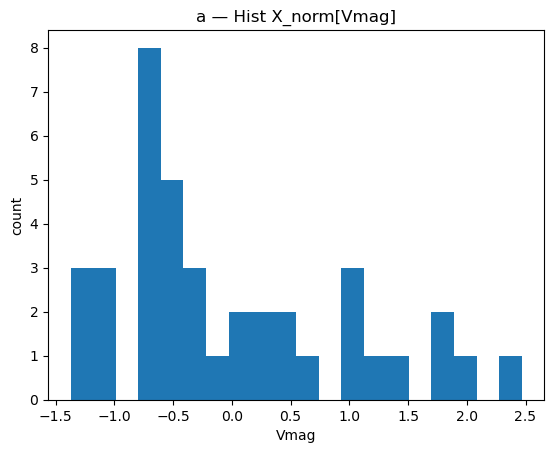

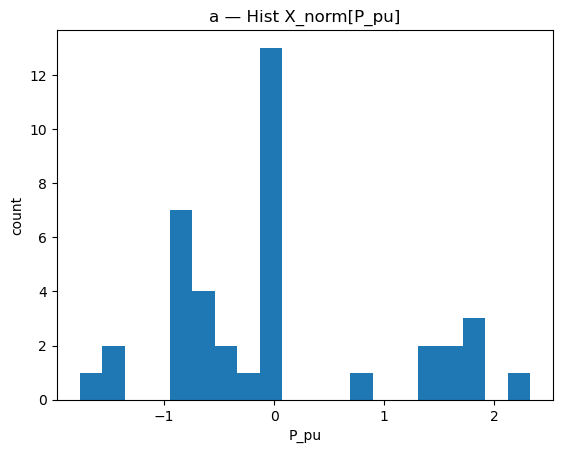

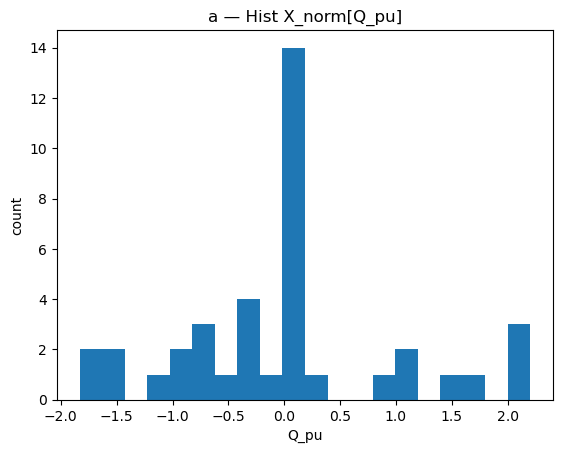

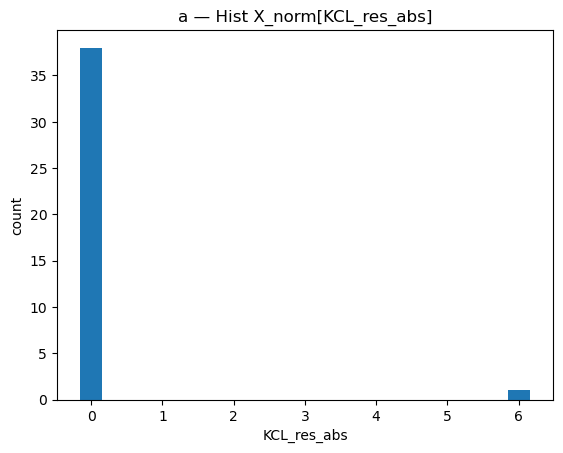

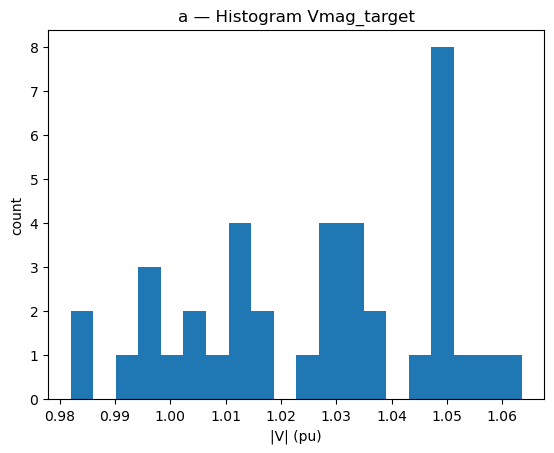

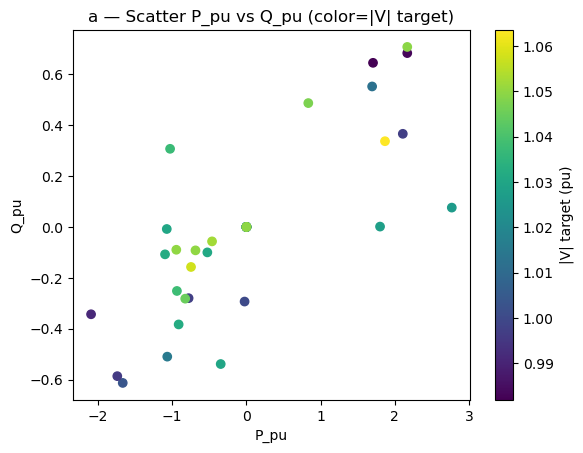

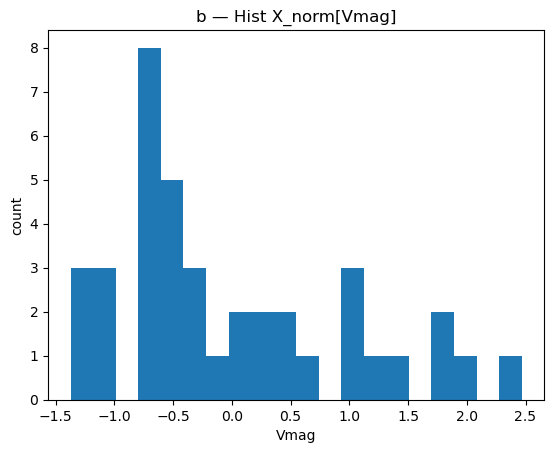

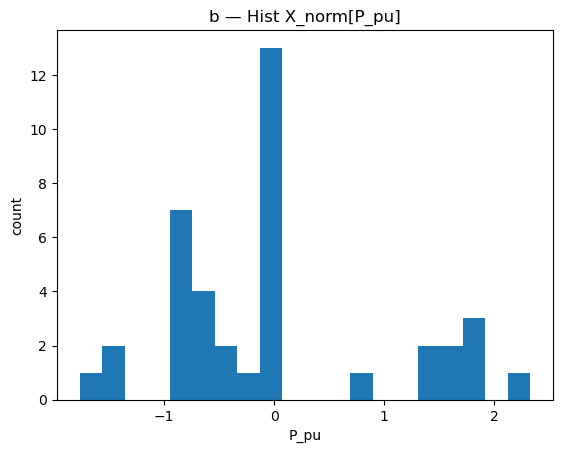

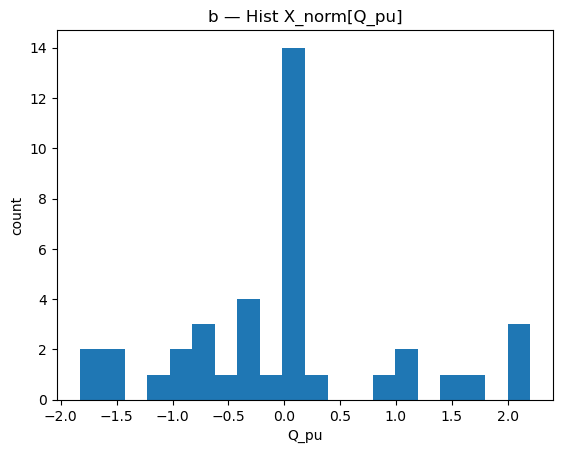

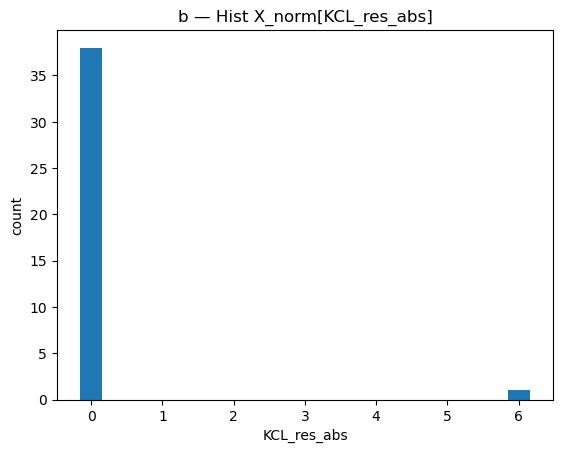

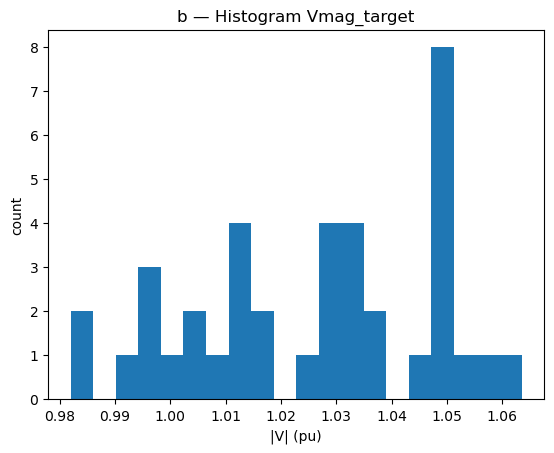

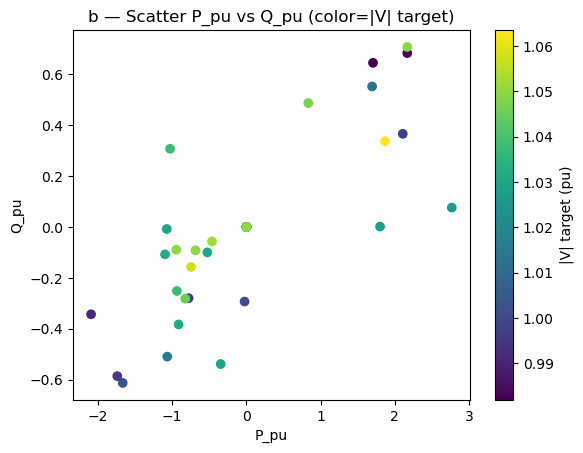

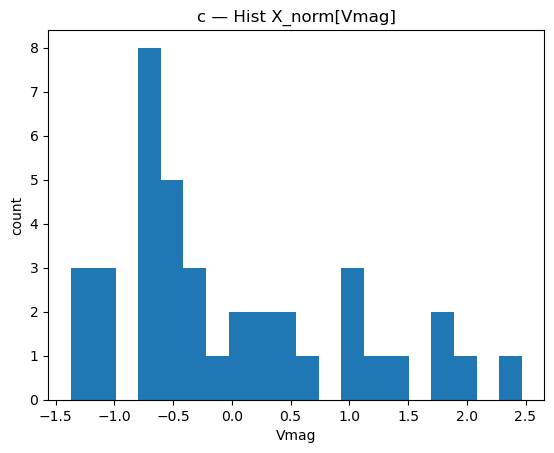

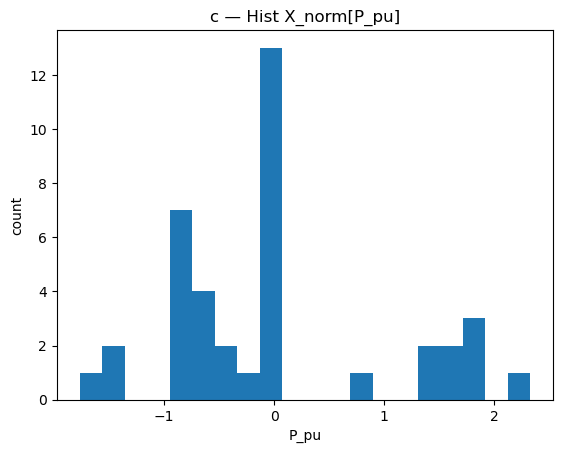

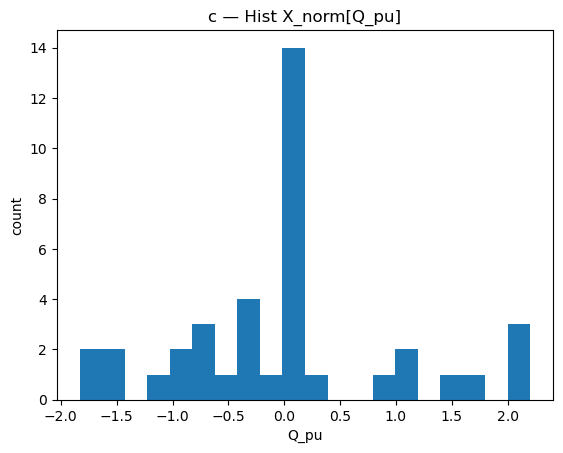

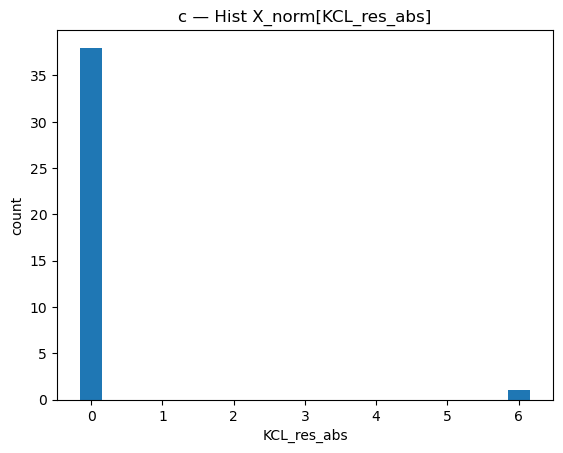

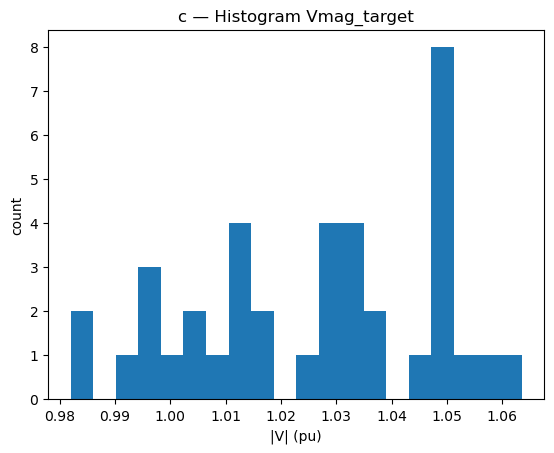

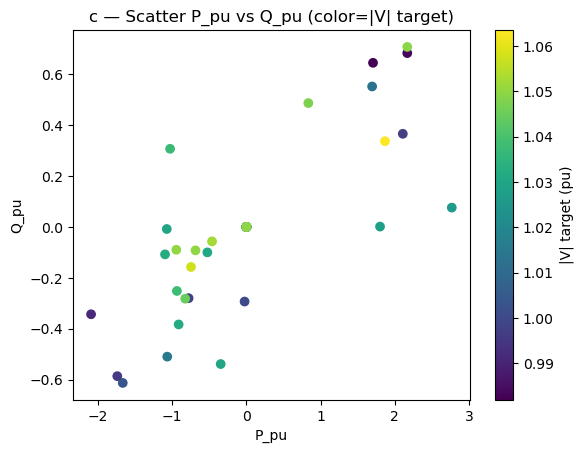


[ok] Phase 8a sanity & plots done.


In [25]:
# ============================================================
# 8a) Dataset sanity checks & visualizations
# ------------------------------------------------------------
# What this cell does:
# - Loads artifacts from Phase 7 (normalization, metadata, per-phase packages)
# - Prints integrity checks (shapes, NaN/Inf counts)
# - Displays quick plots: histograms of X_norm, Vmag_target; scatter P vs Q colored by Vmag
# - Summarizes train/val/test sizes by phase
# ============================================================

import os
import json
import numpy as np
import matplotlib.pyplot as plt

ARTIFACT_DIR = "./artifacts_kan_phase7"   # <- keep in sync with Phase 7

def load_npz(path):
    with np.load(path, allow_pickle=True) as d:
        return {k: d[k] for k in d.files}

def load_artifacts(artifact_dir: str):
    manifest_path = os.path.join(artifact_dir, "manifest.json")
    if not os.path.exists(manifest_path):
        raise FileNotFoundError(f"manifest.json not found in {artifact_dir}")
    with open(manifest_path, "r", encoding="utf-8") as f:
        manifest = json.load(f)

    norm = load_npz(os.path.join(artifact_dir, manifest["files"]["normalization"]))
    meta = load_npz(os.path.join(artifact_dir, manifest["files"]["metadata"]))

    per_phase = {}
    for fname in manifest["files"]["per_phase"]:
        ph = fname.replace("phase_", "").replace(".npz", "")
        per_phase[ph] = load_npz(os.path.join(artifact_dir, fname))
    return manifest, norm, meta, per_phase

manifest, norm, meta, per_phase = load_artifacts(ARTIFACT_DIR)

feature_names = [str(x) for x in norm["feature_names"]]
mu, sigma = norm["mu"], norm["sigma"]
bus_names = list(meta.get("BUS_NAMES", []))
zones = meta.get("BUS_ZONES", None)

print("=== Phase 8a: Artifact manifest ===")
print(json.dumps(manifest, indent=2))
print("\n=== Normalization ===")
print("features:", feature_names)
print("mu[:5]  :", np.round(mu[:5], 6))
print("sigma[:5]:", np.round(sigma[:5], 6))

# ---- Integrity checks & split summary
def check_phase(name, pack):
    keys = list(pack.keys())
    print(f"\n--- {name} ---")
    print("keys:", keys)

    X = pack["X"]; Xn = pack["X_norm"]
    print("X shape:", X.shape, " | X_norm shape:", Xn.shape)

    for arr_name in ["X", "X_norm", "Vmag_target"]:
        arr = pack.get(arr_name, None)
        if arr is not None:
            n_nan = np.isnan(arr).sum()
            n_inf = np.isinf(arr).sum()
            print(f"  {arr_name}: NaN={n_nan}, Inf={n_inf}")

    idx_tr, idx_va, idx_te = pack["idx_train"], pack["idx_val"], pack["idx_test"]
    print(f"Splits sizes -> train={len(idx_tr)}, val={len(idx_va)}, test={len(idx_te)}")

for ph, pack in per_phase.items():
    check_phase(ph, pack)

# ---- Quick plots (per phase)
def plot_hist_features_norm(ph, pack, cols=(0,1,2,3)):
    Xn = pack["X_norm"]
    cols = [c for c in cols if c < Xn.shape[1]]
    for c in cols:
        plt.figure()
        plt.hist(Xn[:, c], bins=20)
        plt.title(f"{ph} — Hist X_norm[{feature_names[c]}]")
        plt.xlabel(feature_names[c]); plt.ylabel("count")
        plt.show()

def plot_vmag_target(ph, pack):
    if "Vmag_target" not in pack: 
        return
    Vmag = np.asarray(pack["Vmag_target"]).astype(float)
    plt.figure()
    plt.hist(Vmag, bins=20)
    plt.title(f"{ph} — Histogram Vmag_target")
    plt.xlabel("|V| (pu)"); plt.ylabel("count")
    plt.show()

def plot_scatter_PQ(ph, pack):
    # Find P,Q indexes in feature_names
    try:
        p_idx = feature_names.index("P_pu")
        q_idx = feature_names.index("Q_pu")
        vmag_t = pack.get("Vmag_target", None)
    except ValueError:
        return
    X = pack["X"]
    P, Q = X[:, p_idx], X[:, q_idx]
    c = np.abs(vmag_t) if vmag_t is not None else None
    plt.figure()
    sc = plt.scatter(P, Q, c=c)
    plt.title(f"{ph} — Scatter P_pu vs Q_pu (color=|V| target)" if c is not None else f"{ph} — Scatter P_pu vs Q_pu")
    plt.xlabel("P_pu"); plt.ylabel("Q_pu")
    if c is not None:
        plt.colorbar(sc, label="|V| target (pu)")
    plt.show()

# Show a few plots for each phase (you can comment out to speed up)
for ph, pack in per_phase.items():
    plot_hist_features_norm(ph, pack, cols=(0,3,4,6))  # Vmag, P, Q, KCL_res_abs
    plot_vmag_target(ph, pack)
    plot_scatter_PQ(ph, pack)

print("\n[ok] Phase 8a sanity & plots done.")


In [26]:
# ============================================================
# 8b) Unified dataset loader (numpy / torch-ready) — corrected
# ------------------------------------------------------------
# What this cell does:
# - Normalizes per_phase keys so both "phase_a" and "phase_phase_a" work
# - Provides GridDataset to read a single phase with split + mask filtering
# - Targets: "Vmag" (scalar), "Vcomplex" (2 channels [Re, Im]), or "none"
# - Optional PyTorch tensors & DataLoader demo
# Prereqs (from Phase 8a):
#   manifest, norm, meta, per_phase = load_artifacts(ARTIFACT_DIR)
# ============================================================

from typing import List, Dict, Tuple, Optional, Union
import numpy as np

# Optional torch backend
try:
    import torch
    from torch.utils.data import DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

def normalize_phase_keys(per_phase: Dict[str, dict]) -> Dict[str, dict]:
    """
    Return a copy of per_phase with normalized keys:
      - drop double prefix 'phase_phase_' -> 'phase_'
      - ensure keys start with 'phase_'
    """
    out = {}
    for k, v in per_phase.items():
        k2 = k.replace("phase_phase_", "phase_")
        if not k2.startswith("phase_"):
            k2 = "phase_" + k2
        out[k2] = v
    return out

# Normalize keys once here (safe no-op if already clean)
per_phase = normalize_phase_keys(per_phase)

class GridDataset:
    """
    Unified loader for a single phase package produced in Phase 7.
    Usage:
        ds = GridDataset(per_phase=per_phase, phase='phase_a', split='train',
                         use_norm=True, targets='Vmag', mask_name=None,
                         to_torch=False, device=None)
        x, y = ds[0]
    """
    def __init__(self,
                 per_phase: Dict[str, dict],
                 phase: str,
                 split: str = "train",
                 use_norm: bool = True,
                 targets: str = "Vmag",          # "Vmag" | "Vcomplex" | "none"
                 mask_name: Optional[str] = None, # 'gen' | 'load' | 'observed' | 'slack' | 'near_zero_P' | None
                 to_torch: bool = False,
                 device: Optional[str] = None):
        # --- Normalize input phase name (accept "phase_a", "phase_phase_a", or just "a")
        phase_norm = phase.replace("phase_phase_", "phase_")
        if not phase_norm.startswith("phase_"):
            if f"phase_{phase_norm}" in per_phase:
                phase_norm = f"phase_{phase_norm}"
            else:
                phase_norm = "phase_" + phase_norm

        if phase_norm not in per_phase:
            raise KeyError(f"phase '{phase}' not found. Available: {list(per_phase.keys())}")

        if split not in ("train", "val", "test", "all"):
            raise ValueError("split must be one of {'train','val','test','all'}")
        if targets not in ("Vmag", "Vcomplex", "none"):
            raise ValueError("targets must be {'Vmag','Vcomplex','none'}")

        self.pack = per_phase[phase_norm]
        self.phase = phase_norm
        self.use_norm = use_norm
        self.targets_mode = targets
        self.to_torch = (to_torch and TORCH_AVAILABLE)
        self.device = device

        # --- Select indices by split
        if split == "all":
            idx = np.arange(self.pack["X"].shape[0])
        else:
            idx = np.asarray(self.pack[f"idx_{split}"], dtype=int)

        # --- Optional mask filtering
        if mask_name is not None:
            mask_key = f"mask_{mask_name}"
            if mask_key not in self.pack:
                raise KeyError(f"Mask '{mask_name}' not found in package (available keys: {list(self.pack.keys())}).")
            m = np.asarray(self.pack[mask_key]).astype(bool)
            idx = idx[m[idx]]

        self.idx = idx

        # --- Feature matrix (normalized or raw)
        self.X = self.pack["X_norm"] if use_norm else self.pack["X"]

        # --- Targets
        if self.targets_mode == "Vmag":
            if "Vmag_target" not in self.pack:
                raise KeyError("Vmag_target not found in package.")
            self.y = np.asarray(self.pack["Vmag_target"], dtype=np.float64)
        elif self.targets_mode == "Vcomplex":
            Vt = self.pack.get("V_target", None)
            if Vt is None:
                raise KeyError("V_target not found for Vcomplex mode.")
            Vt = np.asarray(Vt)
            if np.isrealobj(Vt):
                Vt = Vt + 0j
            self.y = np.stack([Vt.real, Vt.imag], axis=-1).astype(np.float64)
        else:
            self.y = None

        # --- Optional torch conversion
        if self.to_torch:
            self._to_torch_inplace()

    def _to_torch_inplace(self):
        dev = self.device if self.device is not None else ("cuda" if torch.cuda.is_available() else "cpu")
        self.X = torch.as_tensor(self.X, dtype=torch.float32, device=dev)
        if self.y is not None:
            self.y = torch.as_tensor(self.y, dtype=torch.float32, device=dev)

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, i: int):
        ii = self.idx[i]
        Xi = self.X[ii]
        yi = None if self.y is None else self.y[ii]
        return Xi, yi

# --------- Smoke tests (both numpy & torch if available) ----------
try:
    # Accept "phase_a"
    ds_train_a = GridDataset(per_phase=per_phase, phase="phase_a",
                             split="train", use_norm=True,
                             targets="Vmag", mask_name=None,
                             to_torch=False)
    x0, y0 = ds_train_a[0]
    print(f"[ok] GridDataset numpy — {ds_train_a.phase}: x0={x0.shape}, y0={None if y0 is None else np.shape(y0)}")

    # Accept "phase_phase_a" too
    ds_train_a2 = GridDataset(per_phase=per_phase, phase="phase_phase_a",
                              split="train", use_norm=True,
                              targets="Vcomplex", mask_name=None,
                              to_torch=False)
    x1, y1 = ds_train_a2[0]
    print(f"[ok] GridDataset numpy (alt name) — {ds_train_a2.phase}: x1={x1.shape}, y1={None if y1 is None else np.shape(y1)}")
except Exception as e:
    print("[warn] GridDataset numpy test failed:", e)

if TORCH_AVAILABLE:
    try:
        ds_torch = GridDataset(per_phase=per_phase, phase="phase_a",
                               split="train", use_norm=True, targets="Vmag",
                               mask_name=None, to_torch=True, device=None)
        dl = DataLoader(ds_torch, batch_size=16, shuffle=True)
        xb, yb = next(iter(dl))
        print(f"[ok] Torch DataLoader sample: xb={tuple(xb.shape)}, yb={tuple(yb.shape)}")
    except Exception as e:
        print("[warn] Torch DataLoader test failed:", e)
else:
    print("[info] Torch not available — skipped DataLoader demo.")


[ok] GridDataset numpy — phase_a: x0=(8,), y0=()
[ok] GridDataset numpy (alt name) — phase_a: x1=(8,), y1=(2,)
[ok] Torch DataLoader sample: xb=(16, 8), yb=(16,)


In [23]:
# ============================================================
# 9) Proxy Nyström — auto-resolve outputs + run
# ------------------------------------------------------------
# - Scans recursively for BOTH files:
#       selected_landmarks_12.csv
#       interpolation_weights.csv
# - Picks the most recent folder containing both, sets RESULTS_DIR
# - Runs the proxy reconstruction and saves proxy_nystrom_summary.csv
# ============================================================

import os, csv, glob
from typing import Tuple, Dict, Any, Optional, List
import numpy as np

REQUIRED = ("selected_landmarks_12.csv", "interpolation_weights.csv")

def find_all_phase8_output_dirs(start_dirs: List[str]) -> List[str]:
    """Return all folders that contain BOTH required CSVs, sorted by mtime desc."""
    seen = set()
    hits = []
    for base in start_dirs:
        for path in glob.glob(os.path.join(base, "**", REQUIRED[0]), recursive=True):
            d = os.path.dirname(path)
            w = os.path.join(d, REQUIRED[1])
            if os.path.exists(w):
                if d not in seen:
                    seen.add(d)
                    hits.append(d)
    hits.sort(key=lambda p: os.path.getmtime(p), reverse=True)
    return hits

# ---- Try to locate outputs
search_roots = [".", "./results", "./artifacts_kan_phase7", ".."]
candidates = find_all_phase8_output_dirs(search_roots)

print("=== Phase 9 — search results ===")
if candidates:
    for i, d in enumerate(candidates[:10], 1):
        print(f"{i:2d}) {os.path.abspath(d)}  | files: {os.listdir(d)}")
else:
    print("No folders found containing BOTH:", REQUIRED)
    print("Hint: run/locate the selection/export step that writes these two CSVs,")
    print("      then re-run this cell.")
    raise RuntimeError("Phase 8 outputs not found anywhere under project paths.")

# Pick the most recent
RESULTS_DIR = candidates[0]
print("\n[info] Using RESULTS_DIR =", os.path.abspath(RESULTS_DIR))

LM_FILE, W_FILE = REQUIRED

# -------- load landmarks & W ----------
def load_landmarks_and_W(results_dir: str) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
    lm_path = os.path.join(results_dir, LM_FILE)
    w_path  = os.path.join(results_dir, W_FILE)

    # Landmarks
    try:
        lm_struct = np.genfromtxt(lm_path, delimiter=",", names=True, dtype=None, encoding="utf-8")
        if hasattr(lm_struct, "dtype") and lm_struct.dtype.names:
            for col in ("bus_idx","bus","idx","node_idx"):
                if col in lm_struct.dtype.names:
                    landmarks = np.atleast_1d(lm_struct[col]).astype(int)
                    break
            else:
                raw = np.genfromtxt(lm_path, delimiter=",", dtype=str)
                landmarks = raw[1:, 0].astype(int) if raw.ndim > 1 else np.atleast_1d(int(raw))
        else:
            raw = np.genfromtxt(lm_path, delimiter=",", dtype=int)
            landmarks = raw[:,0] if raw.ndim > 1 else np.atleast_1d(raw)
    except Exception:
        raw = np.genfromtxt(lm_path, delimiter=",", dtype=int)
        landmarks = raw[:,0] if raw.ndim > 1 else np.atleast_1d(raw)

    # Weights (with/without bus_idx col)
    u_index = None
    try:
        w_named = np.genfromtxt(w_path, delimiter=",", names=True, dtype=None, encoding="utf-8")
        names = list(w_named.dtype.names) if hasattr(w_named, "dtype") and w_named.dtype.names else []
        if "bus_idx" in names:
            u_index = np.atleast_1d(w_named["bus_idx"]).astype(int)
            weight_cols = [c for c in names if c != "bus_idx"]
            W = np.vstack([w_named[c] for c in weight_cols]).T.astype(np.float64)
        else:
            arr = np.genfromtxt(w_path, delimiter=",", dtype=np.float64, skip_header=1)
            if arr.ndim == 1:
                arr = arr.reshape(1, -1)
            W = arr
    except Exception:
        arr = np.genfromtxt(w_path, delimiter=",", dtype=np.float64)
        if np.isnan(arr).any():
            arr = np.genfromtxt(w_path, delimiter=",", dtype=np.float64, skip_header=1)
        if arr.ndim == 1:
            arr = arr.reshape(1, -1)
        W = arr

    return landmarks.astype(int), W.astype(np.float64), (None if u_index is None else u_index.astype(int))

def infer_u_index(n_buses: int, landmarks: np.ndarray) -> np.ndarray:
    all_idx = np.arange(n_buses, dtype=int)
    mask = np.ones(n_buses, dtype=bool)
    mask[np.asarray(landmarks, dtype=int)] = False
    return all_idx[mask]

# ---- require per_phase from 8a ----
if "per_phase" not in globals():
    raise RuntimeError("per_phase not found. Run Phase 8a first to load artifacts.")

# normalize phase keys if needed
if not any(k.startswith("phase_") for k in per_phase.keys()):
    per_phase = { (k if k.startswith("phase_") else f"phase_{k}"): v for k,v in per_phase.items() }

def get_voltages(pack: Dict[str, Any]):
    # complex first
    vobs = None
    for k in ("V_target","V_obs","V_measured","V_complex_target","Vcomplex_target"):
        if k in pack and pack[k] is not None:
            vobs = np.asarray(pack[k]); break
    vphy = None
    for k in ("V_phys","V_powerflow","V_ref","V_complex_phys","Vcomplex_phys"):
        if k in pack and pack[k] is not None:
            vphy = np.asarray(pack[k]); break
    if vobs is not None and vphy is not None:
        if np.isrealobj(vobs): vobs = vobs + 0j
        if np.isrealobj(vphy): vphy = vphy + 0j
        return vobs, vphy, True

    # magnitudes
    vmag_obs = None
    for k in ("Vmag_target","Vmag_obs","Vmag_measured"):
        if k in pack and pack[k] is not None:
            vmag_obs = np.asarray(pack[k], dtype=np.float64); break
    vmag_phys = None
    for k in ("Vmag_phys","Vmag_powerflow","Vmag_ref","V_phys_mag","V_ref_mag"):
        if k in pack and pack[k] is not None:
            vmag_phys = np.asarray(pack[k], dtype=np.float64); break
    if vmag_obs is None or vmag_phys is None:
        raise KeyError("Could not find V_obs/V_phys (complex or Vmag) in pack.")
    return vmag_obs, vmag_phys, False

def proxy_nystrom_for_phase(pack: Dict[str, Any],
                            landmarks: np.ndarray,
                            W: np.ndarray,
                            u_index: Optional[np.ndarray]) -> Dict[str, float]:
    V_obs, V_phys, is_complex = get_voltages(pack)
    N = V_obs.shape[0]
    if u_index is None: u_index = infer_u_index(N, landmarks)
    u_index = np.asarray(u_index, dtype=int)

    R = int(np.asarray(landmarks).shape[0])
    U = int(np.asarray(u_index).shape[0])
    assert W.shape == (U, R), f"W shape mismatch: got {W.shape}, expected ({U},{R})"

    if is_complex:
        r_true = V_obs - V_phys
        r_R_true = r_true[landmarks]
        r_U_hat  = (W @ r_R_true.reshape(R, 1)).reshape(U,)
        r_hat = np.zeros(N, dtype=np.complex128)
        r_hat[landmarks] = r_R_true
        r_hat[u_index]   = r_U_hat
        return {
            "mae_abs": float(np.mean(np.abs(np.abs(r_hat) - np.abs(r_true)))),
            "mae_re":  float(np.mean(np.abs(r_hat.real - r_true.real))),
            "mae_im":  float(np.mean(np.abs(r_hat.imag - r_true.imag))),
        }
    else:
        r_abs_true = np.abs(V_obs - V_phys).astype(np.float64)
        r_R_true = r_abs_true[landmarks]
        r_U_hat  = (W @ r_R_true.reshape(R, 1)).reshape(U,)
        r_abs_hat = np.zeros_like(r_abs_true, dtype=np.float64)
        r_abs_hat[landmarks] = r_R_true
        r_abs_hat[u_index]   = r_U_hat
        return {"mae_abs": float(np.mean(np.abs(r_abs_hat - r_abs_true)))}

# ---- run
LANDMARKS, W, U_INDEX = load_landmarks_and_W(RESULTS_DIR)

summary_rows: List[Dict[str, float]] = []
for phase_k in sorted(per_phase.keys()):
    try:
        metrics = proxy_nystrom_for_phase(per_phase[phase_k], LANDMARKS, W, U_INDEX)
        row = {"phase": phase_k, **metrics}
        summary_rows.append(row)
        print(f"[ok] Proxy Nyström {phase_k}:", row)
    except Exception as e:
        print(f"[warn] Proxy Nyström failed for {phase_k}: {e}")

# save
summary_path = os.path.join(RESULTS_DIR, "proxy_nystrom_summary.csv")
with open(summary_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["phase","mae_abs","mae_re","mae_im"])
    writer.writeheader()
    for r in summary_rows:
        for k in ("mae_abs","mae_re","mae_im"):
            if k not in r: r[k] = ""
        writer.writerow(r)

print(f"[saved] {summary_path}")


=== Phase 9 — search results ===
No folders found containing BOTH: ('selected_landmarks_12.csv', 'interpolation_weights.csv')
Hint: run/locate the selection/export step that writes these two CSVs,
      then re-run this cell.


RuntimeError: Phase 8 outputs not found anywhere under project paths.